### Problem statement:
Plant disease affects the quality of fruits, vegetables and causes heavy loss in production. Present method is manual that involve by observing leaf. To overcome this problem our plant disease model is beneficial.
To build a CNN based model which can accurately detect plant disease. A solution which can evaluate images and alert the farmers about the presence of disease.

[Dataset is taken from this kaggle dataset](https://www.kaggle.com/arjuntejaswi/plant-village)

Dataset contain healthy and unhealthy plant leaf images. 
This dataset contain about 20K images of plant leaf images. The dataset contains 15 sub-directories of plant disease images. 

- Pepper__bell___Bacterial_spot
- Pepper__bell___healthy
- Potato___Early_blight
- Potato___Late_blight
- Potato___healthy
- Tomato_Bacterial_spot
- Tomato_Early_blight
- Tomato_Late_blight
- Tomato_Leaf_Mold
- Tomato_Septoria_leaf_spot
- Tomato_Spider_mites_Two_spotted_spider_mite
- Tomato__Target_Spot
- Tomato__Tomato_YellowLeaf__Curl_Virus
- Tomato__Tomato_mosaic_virus
- Tomato_healthy



From each class random 600 images are picked for model building.

### Importing all the important libraries

In [1]:
import pathlib
from glob import glob
import fnmatch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# #Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [5]:

# Defining the path for train and \test images
train_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle_Project/Plant Disease Project/new_dataset/train/"
test_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle_Project/Plant Disease Project/new_dataset/test/"

train_path = '../input/new-dataset-plant/new_dataset/train/'
test_path = '../input/new-dataset-plant/new_dataset/test/'

data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

# Defining the path to store model
model_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle_Project/Plant Disease Project/models'

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.JPG')))
print("Train image count", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.JPG')))
print("Test image count", image_count_test)

Train image count 7004
Test image count 1346


### Create a dataset

Define some parameters for the loader:

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 7004 files belonging to 15 classes.
Using 5604 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 7004 files belonging to 15 classes.
Using 1400 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path ,
    shuffle=True,
    # seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 1346 files belonging to 15 classes.


In [11]:
class_names = train_ds.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

### Visualize the data
#### Visualize one instance of all  classes present in the dataset

In [12]:
temp_class = []
temp_dict = {}
for images, labels in train_ds:
    for i, val in enumerate(class_names):
        if class_names[labels[i]] not in temp_class:
          temp_class.append(class_names[labels[i]])
          temp_dict[class_names[labels[i]]] = images[i].numpy().astype("uint8")
    if len(temp_class) == len(class_names):
        break

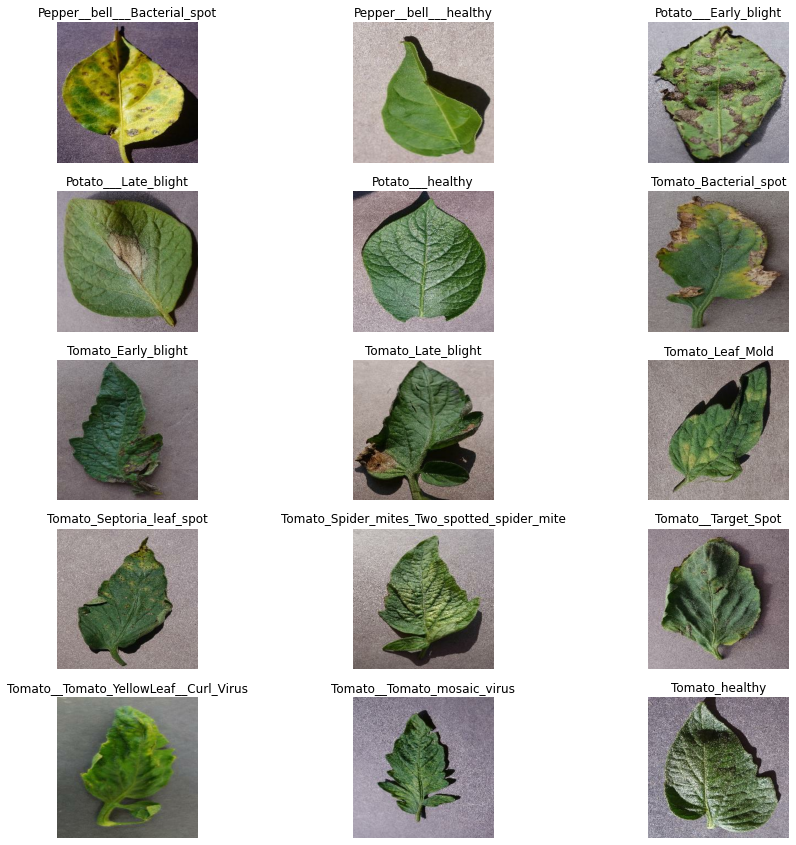

In [13]:
plt.figure(figsize=(15, 15))
for i in range(len(class_names)):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(temp_dict[class_names[i]])
    plt.title(class_names[i])
    plt.axis("off")

del temp_class
del temp_dict

In [14]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [15]:
# train_ds, test_ds, val_ds = get_dataset_partition_tf(dataset)

In [16]:
print("Training size:", len(train_ds)*BATCH_SIZE)
print("Validation size:", len(val_ds)*BATCH_SIZE)
print("Testing size:", len(test_ds)*BATCH_SIZE)

Training size: 5632
Validation size: 1408
Testing size: 1376


In [17]:
# del dataset

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data normalization

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data augmentation

In [20]:
data_augmentation = keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Train the model

### Create the model

In [21]:
# input shape of (img_height, img_width, 3)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [22]:
# ### Your code goes here

# model = Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
# #     layers.Conv2D(64, (3,3), activation='relu'),
# #     layers.MaxPooling2D((2, 2)),

# #     layers.Conv2D(128, (3,3), activation='relu'),
# #     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dense(n_classes, activation='softmax')
# ])

# model.build(input_shape)

In [23]:
### Your code goes here

model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.20),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.20),    
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
dropout (Dropout)            (32, 62, 62, 64)         

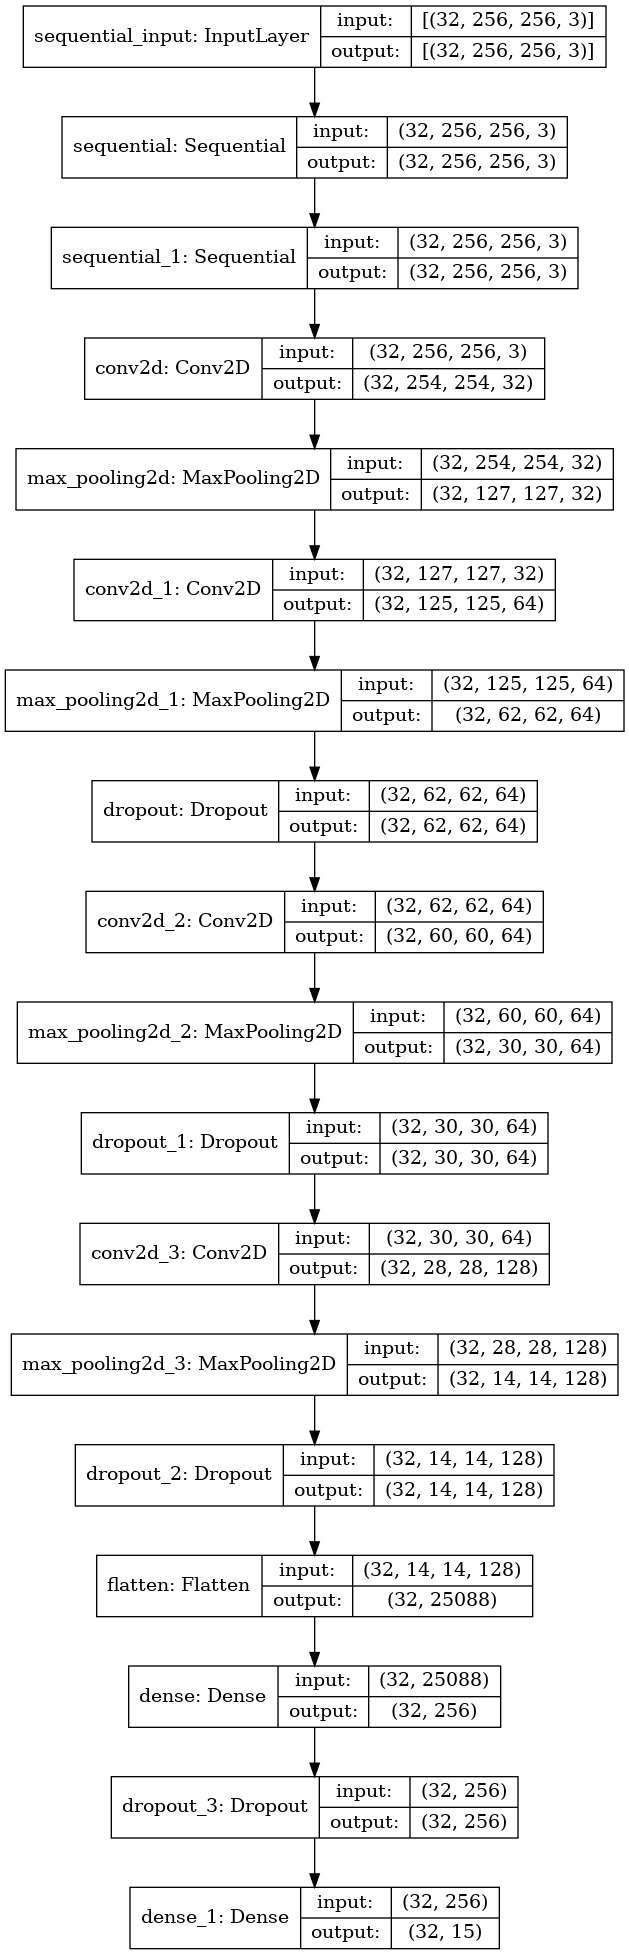

In [26]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Train the model

In [27]:
%%time
EPOCHS = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/30
176/176 [==============================] - 57s 95ms/step - loss: 2.6305 - accuracy: 0.1520 - val_loss: 1.6857 - val_accuracy: 0.4443
Epoch 2/30
176/176 [==============================] - 7s 40ms/step - loss: 1.5225 - accuracy: 0.5061 - val_loss: 1.3016 - val_accuracy: 0.5714
Epoch 3/30
176/176 [==============================] - 7s 40ms/step - loss: 1.1153 - accuracy: 0.6207 - val_loss: 1.2359 - val_accuracy: 0.6043
Epoch 4/30
176/176 [==============================] - 7s 40ms/step - loss: 0.9323 - accuracy: 0.6880 - val_loss: 1.2825 - val_accuracy: 0.6086
Epoch 5/30
176/176 [==============================] - 7s 40ms/step - loss: 0.8669 - accuracy: 0.7128 - val_loss: 0.8844 - val_accuracy: 0.7150
Epoch 6/30
176/176 [==============================] - 7s 40ms/step - loss: 0.7088 - accuracy: 0.7608 - val_loss: 0.9108 - val_accuracy: 0.7057
Epoch 7/30
176/176 [==============================] - 7s 40ms/step - loss: 0.6266 - accuracy: 0.7936 - val_loss: 1.4408 - val_accuracy: 0.612

### Visualizing training results

In [28]:
# del train_ds
# del val_ds

In [29]:
# Function to visualize training result
def visualize_train_result(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

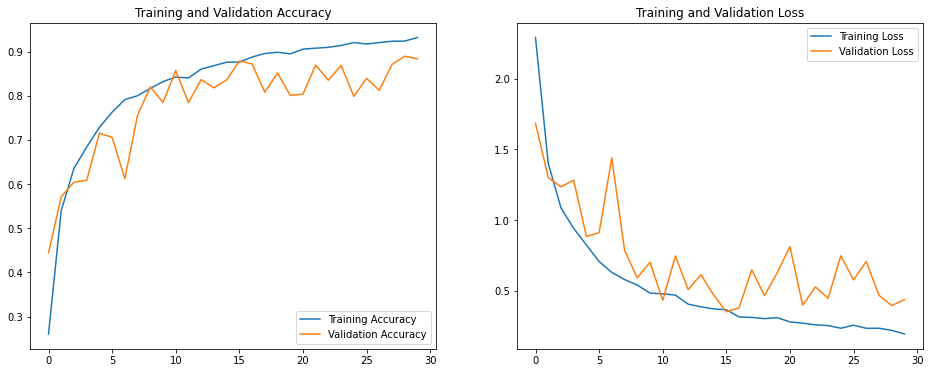

In [30]:
visualize_train_result(history, EPOCHS)

### Let's predict on test data
### Visualize actual and predicted image by model

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

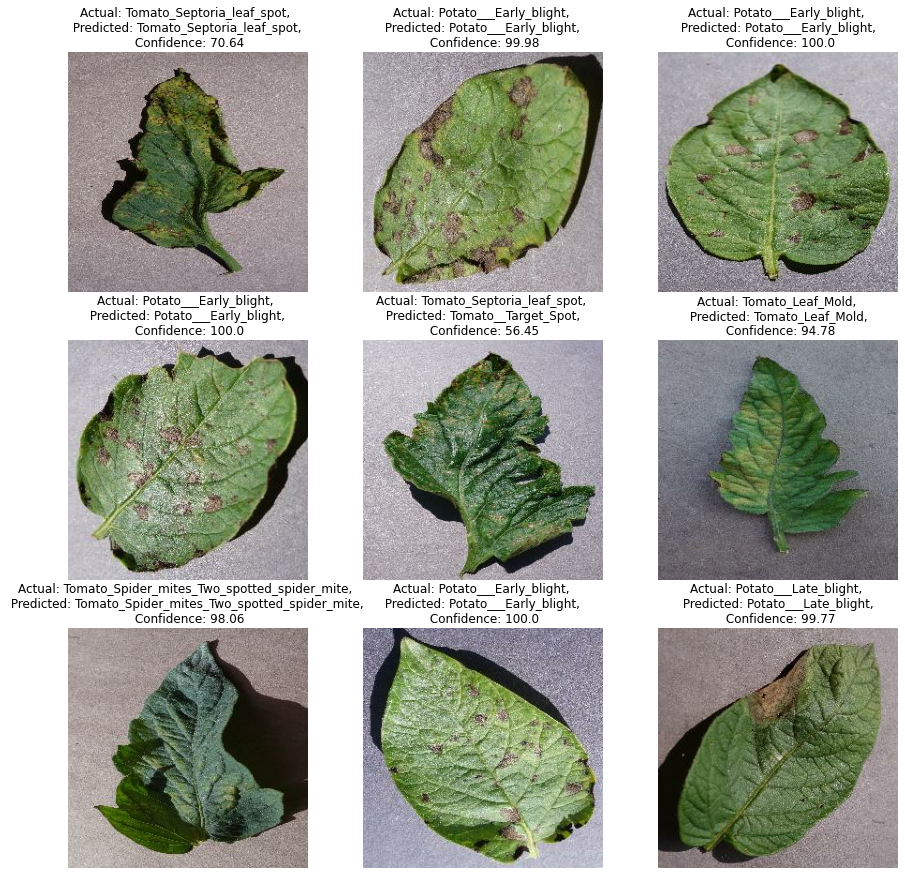

In [32]:
plt.figure(figsize=(15, 15))
tak = test_ds.take(1)
for images, labels in tak:
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)

        plt.imshow(images[i].numpy().astype("uint8"))
        image_1 = images[i].numpy()
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")        
        plt.axis("off")
del tak

**From above visualization we can see model is predicting disease correctly on test data**

### Save model
### Create models folder and store trained model

In [33]:
import shutil
def save_model(model_path, save=False):
#     # Delete folder if exists
#     if os.path.exists(model_path):
#         print(f"Folder {model_path} is exist. Deleting folder.")
#         shutil.rmtree(model_path)

    # Create folder if not exists    
    if not os.path.exists(model_path):
        print(f"Path {model_path} is not exist. Creating folder to store models.")
        os.mkdir(model_path)

    # get train and val accuracy
    train_acc = round(history.history['accuracy'][-1], 2)
    val_acc = round(history.history['val_accuracy'][-1], 2)

    model_version = len(os.listdir(model_path)) + 1
    model_name = f"all_model_{model_version}_train_{train_acc}_val_{val_acc}"
    model_name_path = f'{model_path}/{model_name}'
    
    if save:
        # save model
        model.save(model_name_path)
        model.save(f'{model_name_path}_h5/my_model.h5')
#         model.save('./models/my_model.h5')
        print(f"Model '{model_name}' is saved successfully to path '{model_path}' !!")

In [34]:
model_path = './models'

if not os.path.exists(model_path):
    os.mkdir('./models')

In [37]:
save_model(model_path, save=True)

Model 'all_model_1_train_0.93_val_0.88' is saved successfully to path './models' !!


In [36]:
# shutil.rmtree(model_path)